# Comparing <tt>beamconv</tt> and <tt>ducc</tt>
In this script, we run some tests to verify the good agreement of the time-ordered data (TOD) returned by <tt>beamconv</tt> and <tt>ducc</tt>.

Note that there are some differences in the conventions assumed by the two codes. In particular,
- $\psi_\texttt{beamconv} = 180 - \psi_\texttt{ducc}$;
- If $q_\texttt{beamconv}=\{q_0,q_1,q_2,q_3\}$, ducc needs $q_\texttt{ducc} = \{-q_1,q_2,q_3,q_0\}$.

Everytime we deal with these differences in the code, we'll highlight it with a <tt>#CONVENTIONS!</tt> comment.

There are some additional discrepancies in the output returned by the two frameworks. We are currently working to better understand the underlying differences. In particular:
- <tt>beamconv</tt> and <tt>ducc</tt> handle the pointings at the North pole differently (see discussion in 1.3.1);
- It is not clear how <tt>beamconv</tt> defines a Gaussian beam, given its full-width-half-maximum (see discussion in 4);
- If <tt>use_l2_scan = True</tt> and <tt>ctim0</tt> is set to 0, <tt>beamconv</tt>'s scanning strategy changes abruptly.

Finally, there is a difference in the interpolation strategy used by <tt>beamconv</tt> and <tt>ducc</tt>, which results in small deviations at the TOD level (see [here](#interpolation)).

## 1 One boresight detector

First, we consider the simpler case of a detector at boresight.

### 1.1 Everything random

This section is based on [comparison_script.py](https://github.com/AdriJD/beamconv/blob/muellerconvolver_comparison/comparison_script.py) from the muellerconvolver_comparison branch of <tt>beamconv</tt>. We consider random scanning strategy, beams and HWP Mueller matrix, and compare the TOD.

First, we need to import a few useful libraries.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import mueller_convolver
import ducc0
import utils

from beamconv import Beam, ScanStrategy, tools
import qpoint as qp

import scanning_mod

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

And set up some variables.

In [2]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))

nside = 64
lmax = 2*nside
kmax = 18
npix = 12*nside**2

We define <b>completely random beam, sky spherical harmonics coefficients and HWP Mueller matrix</b>.

In [3]:
# completely random beam
random_blm = utils.make_full_random_alm(lmax, kmax, rng)
# completely random sky
random_slm = utils.make_full_random_alm(lmax, lmax, rng)
# completely random Mueller matrix
random_mueller = np.random.uniform(-1,1,size=(4,4))

To keep our test as general as possible, we define some <b>completely random pointings</b>

In [4]:
nptg=100
random_ptg = np.empty((nptg,3))
random_ptg[:,0]=np.random.uniform(0,np.pi,size=(nptg,))       # theta
random_ptg[:,1]=np.random.uniform(0,2*np.pi,size=(nptg,))     # phi
random_ptg[:,2]=np.random.uniform(0,2*np.pi,size=(nptg,))     # psi
random_hwp_angles = np.random.uniform(0,2*np.pi,size=(nptg,)) # alpha

Given the specifics we just introduced, we can simulate the TOD with <tt>beamconv</tt> by means of the <tt>get_beamconv_values</tt> function defined in <tt>utils.py</tt>. Note that the function takes care of the different conventions used in <tt>qpoint</tt> and <tt>MuellerConvolver</tt>. See line 45 of <tt>utils.py</tt>:

<tt>psi = 180. - np.degrees(ptg[:,2]) #CONVENTIONS!</tt>!

In [5]:
# get the signal from beamconv
TOD_beamconv_random = utils.get_beamconv_values(lmax=lmax, kmax=kmax, slm=random_slm, blm=random_blm, 
                                               ptg=random_ptg, hwp_angles=random_hwp_angles, mueller=random_mueller, 
                                               mu_con_hwp=True, mu_con_spin=True)

We then simulate the TOD using <tt>ducc</tt>.

In [6]:
# now do the same thing with MuellerConvolver
fullconv_random = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=random_blm,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
TOD_muellerconvolver_random = fullconv_random.signal(ptg=random_ptg, alpha=random_hwp_angles)

To compare the two TOD, we print the L2 error and plot them, together with their difference.

In [7]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(TOD_beamconv_random, TOD_muellerconvolver_random))

L2 error to beamconv + HWP + spin: 0.0077483096084764455


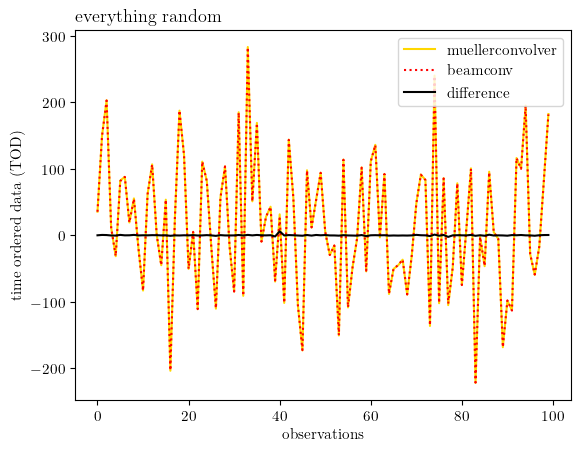

In [8]:
diff_random = TOD_muellerconvolver_random - TOD_beamconv_random

# plotting diff
plt.plot(TOD_muellerconvolver_random, color='gold', label="muellerconvolver")
plt.plot(TOD_beamconv_random, color='red', linestyle=':', label="beamconv")
plt.plot(diff_random, color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random', loc='left')
plt.show()

The small discrepancies between the two TOD improve if we consider a more regular (Gaussian) beam.

### 1.2 Gaussian beam (instead of random)

Given different beam specifics, we can re-run the same lines as before and compare the TOD in this case.

In [9]:
fwhm_arcmin = 5.
fwhm_rad = np.radians(fwhm_arcmin/60.)

# completely random beam
blm_gauss = utils.make_full_random_alm(lmax, kmax, rng)

# ... or use a Gauss beam
blmtmp = utils.blm_gauss_new(fwhm_rad,lmax,pol=True)
blm_gauss *= 0
blm_gauss[0:3, 0:blmtmp.shape[1]] = blmtmp

In [10]:
# get the signal from beamconv
TOD_beamconv_gauss = utils.get_beamconv_values(lmax=lmax, kmax=kmax, slm=random_slm, blm=blm_gauss, 
                                         ptg=random_ptg, hwp_angles=random_hwp_angles, mueller=random_mueller, 
                                         mu_con_hwp=True, mu_con_spin=True)

In [11]:
# now do the same thing with MuellerConvolver
fullconv_gauss = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
TOD_muellerconvolver_gauss = fullconv_gauss.signal(ptg=random_ptg, alpha=random_hwp_angles)

We print again the L2 error, which is less than half the fully random value.

In [12]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(TOD_beamconv_gauss, TOD_muellerconvolver_gauss))

L2 error to beamconv + HWP + spin: 0.0031168161395581763


The improvement with respect to the previous case is visible by eye in the plots below.

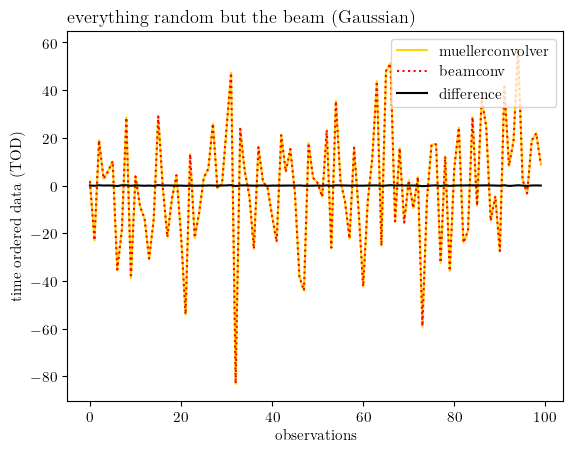

In [13]:
diff_gauss = TOD_muellerconvolver_gauss - TOD_beamconv_gauss

# plotting diff
plt.plot(TOD_muellerconvolver_gauss, color='gold', label="muellerconvolver")
plt.plot(TOD_beamconv_gauss, color='red', linestyle=':', label="beamconv")
plt.plot(diff_gauss, color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('everything random but the beam (Gaussian)', loc='left')
plt.show()

We can also compare the difference in the TOD for the random and Gaussian beams.

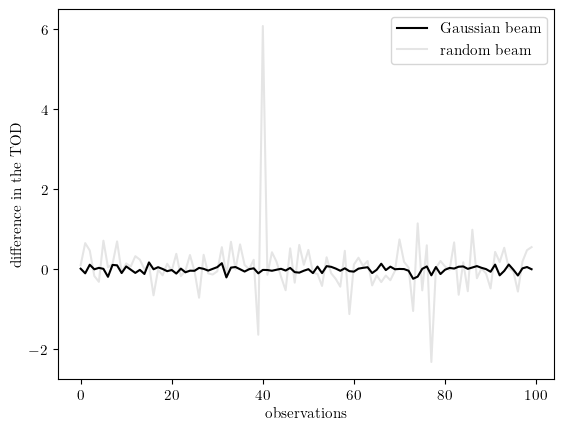

In [14]:
# plotting diff
plt.plot(diff_gauss, color='black', label="Gaussian beam")
plt.plot(diff_random, color='black', alpha=0.1, label="random beam")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('difference in the TOD')
plt.show()

### 1.3 Dummy scanning strategy (instead of random)

Instead of using completely random pointings, we define a simple (non realistic) scanning strategy and test the agreement between <tt>beamconv</tt>'s and <tt>ducc</tt>'s TOD. This is an intermediate step before considering a LiteBIRD-like scanning strategy.

In [15]:
duration = 3600*24                    # mission duration in s (1 day)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

t_samp_array = np.arange(nsamp)/fsamp # array of the sampled times

def ctime_test(**kwargs):
    return np.zeros(kwargs.pop('end')-kwargs.pop('start'))

In [16]:
ptg = np.empty((nsamp,3))             # initializing pointings array
ptg[:,0]=np.pi*np.arange(nsamp)/nsamp # theta
ptg[:,1]=np.radians(55.66)            # phi
ptg[:,2]=np.arange(nsamp)*1e-4        # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra = np.degrees(ptg[:,1])
dec = 90. - np.degrees(ptg[:,0])
# Adjustment for difference in convention between qpoint and MuellerConvolver?
psi = 180. - np.degrees(ptg[:,2]) #CONVENTIONS!

# calculate the boresight quaternions
q_bore_array = qp.QPoint().radecpa2quat(ra, dec, psi)

def q_bore_test(**kwargs):
    return q_bore_array[kwargs.pop('start'):kwargs.pop('end')]

In [17]:
# provide HWP stuff
omega_hwp = 2*np.pi/3600                       #[rad per second]
hwp_angles = np.arange(nsamp)/fsamp*omega_hwp

Given the scanning strategy, we can introduce our boresight detector.

In [18]:
ndet = 1

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
deads = np.array([[0,1]])

And finally run <tt>beamconv</tt> and <tt>ducc</tt>.

from line 4556 of instrument.py: [1. 0. 0. 0.]


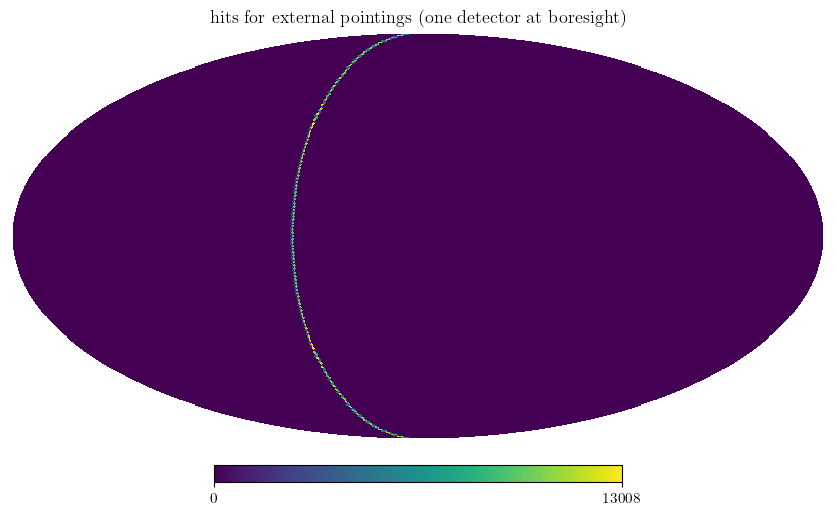

In [19]:
# prepare PO beam file
blm2 = np.zeros((blm_gauss.shape[0], hp.Alm.getsize(lmax=lmax)), dtype=np.complex128)
blm2[:,:blm_gauss.shape[1]] = blm_gauss
blmm, blmp = tools.eb2spin(blm2[1],blm2[2])
blm2[1] = blmm
blm2[2] = blmp
np.save("gaussian_beam.npy", blm2)

# setting up the beam options
beam_opts_boresight = dict(btype='PO',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           po_file="gaussian_beam.npy",
                           hwp_mueller=random_mueller)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.degrees(hwp_angles))

# determine nside_spin necessary for good accuracy
nside_spin = 1
while nside_spin < 4*lmax:
    nside_spin *= 2

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (one detector at boresight)')

TOD_beamconv_dummy = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()

del(S_ptg, cond)

In [20]:
# now do the same thing with MuellerConvolver
fullconv_dummy = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
TOD_muellerconvolver_dummy = fullconv_dummy.signal(ptg=ptg, alpha=hwp_angles)

The L2 error is a bit higher than the previous case, due to the observations near the North pole that return different values.

In [21]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(TOD_beamconv_dummy, TOD_muellerconvolver_dummy))

L2 error to beamconv + HWP + spin: 0.019010253972308485


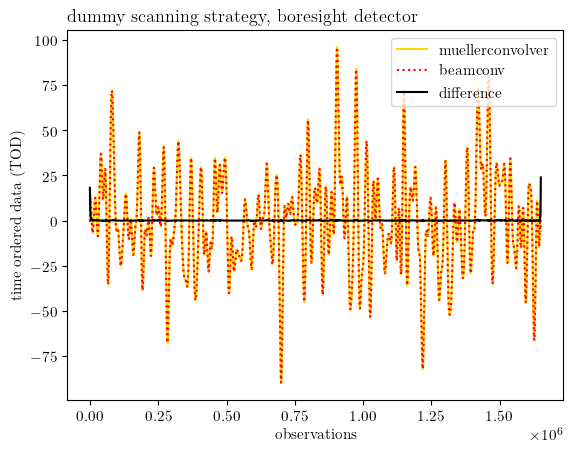

In [22]:
diff_dummy = TOD_muellerconvolver_dummy - TOD_beamconv_dummy

# plotting diff
plt.plot(TOD_muellerconvolver_dummy, color='gold', label="muellerconvolver")
plt.plot(TOD_beamconv_dummy, color='red', linestyle=':', label="beamconv")
plt.plot(diff_dummy, color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy, boresight detector', loc='left')
plt.show()

The situation improves dramatically if we compute the L2 error excluding the first observations corresponding to the first and last pixels.

In [23]:
# observed pixels
pixs = hp.ang2pix(nside, ptg[:,0], ptg[:,1])

# removing North pole
whr_wo_min = np.where(pixs!=np.min(pixs))
pix_wo_min = pixs[whr_wo_min]
idx_wo_min = np.arange(nsamp)[whr_wo_min]

# removing South pole as well
whr_wo_both = np.where(pix_wo_min!=np.max(pix_wo_min))
pix_wo_both = pix_wo_min[whr_wo_both]
idx_wo_both = idx_wo_min[whr_wo_both]

In [24]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(TOD_beamconv_dummy[idx_wo_both], TOD_muellerconvolver_dummy[idx_wo_both]))

L2 error to beamconv + HWP + spin: 0.003317442367464932


<a id='interpolation'></a>Note the small differences between the two TOD in the plot below. They are likely due to the different interpolation schemes assumed by the two framework: if we are not looking at the center of the pixel, we expect discrepancies.

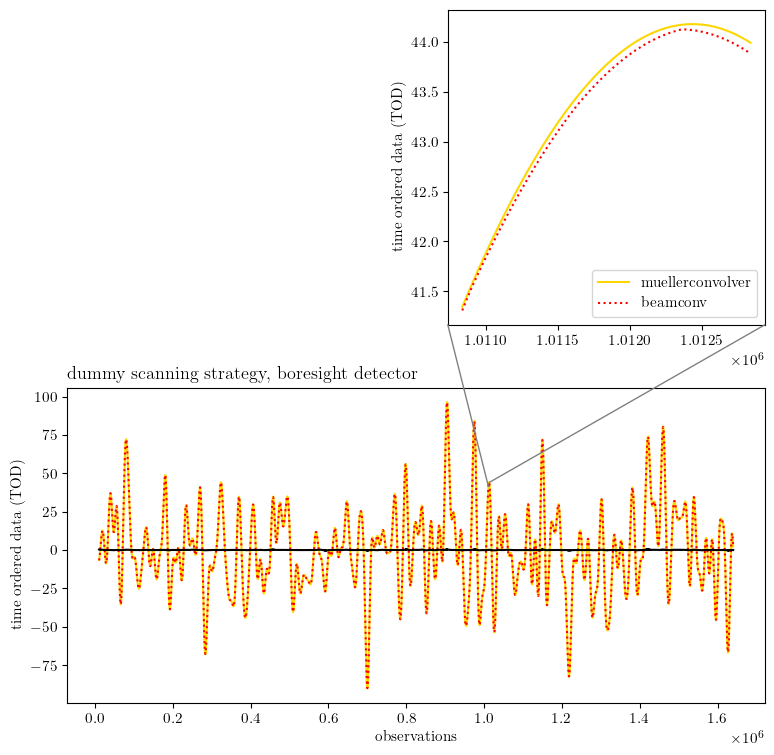

In [25]:
from matplotlib.patches import ConnectionPatch

# Create figures / axes
fig = plt.figure(figsize=(9, 9))
top_right = fig.add_subplot(2, 2, 2)
bottom = fig.add_subplot(2, 1, 2)
fig.subplots_adjust(hspace=.2)

bottom.plot(idx_wo_both, TOD_muellerconvolver_dummy[idx_wo_both], color='gold', label="muellerconvolver")
bottom.plot(idx_wo_both, TOD_beamconv_dummy[idx_wo_both], color='red', linestyle=':', label="beamconv")
bottom.plot(idx_wo_both, diff_dummy[idx_wo_both], color='black', label="difference")
bottom.set_xlabel('observations')
bottom.set_ylabel('time ordered data (TOD)')
bottom.set_title('dummy scanning strategy, boresight detector', loc='left')

top_right.plot(idx_wo_both[1000000:1002001],TOD_muellerconvolver_dummy[idx_wo_both][1000000:1002001], color='gold', label="muellerconvolver")
top_right.plot(idx_wo_both[1000000:1002001],TOD_beamconv_dummy[idx_wo_both][1000000:1002001], color='red', linestyle=':', label="beamconv")
top_right.legend()
top_right.set_ylabel('time ordered data (TOD)')

# Add the connection patches
fig.add_artist(ConnectionPatch(
    xyA=(0, 0), coordsA=top_right.transAxes,
    xyB=(idx_wo_both[1000000],TOD_muellerconvolver_dummy[idx_wo_both][1000000]), coordsB=bottom.transData,
    color='gray'
))

fig.add_artist(ConnectionPatch(
    xyA=(1, 0), coordsA=top_right.transAxes,
    xyB=(idx_wo_both[1002000],TOD_muellerconvolver_dummy[idx_wo_both][1002000]), coordsB=bottom.transData,
    color='gray'
))

plt.show()

#### 1.3.1 Better understanding differences at the poles <font color="red">[in progress]</font>
As a first step to understand why <tt>beamconv</tt> and <tt>ducc</tt> return different TOD at the North and South pole, consider a rotating beam pointing at the North pole and check the two output. Depending on the beam's specifics, we expect different behaviours of the TOD:
- Gaussian non-polarized beam: constant TOD;
- Gaussian polarized beam: oscillations due to the beam's rotation;
- more complex beams: different oscillations (depending on the beam's <tt>mmax</tt>).

In [26]:
duration_North = 3600                             # mission duration in s (1 hour)
nsamp_North = int(duration_North*fsamp)           # number of samples

t_samp_array_North = np.arange(nsamp_North)/fsamp # array of the sampled times

def ctime_test_North(**kwargs):
    return np.zeros(kwargs.pop('end')-kwargs.pop('start'))

In [27]:
ptg_North = np.empty((nsamp_North,3))                     # initializing pointings array
ptg_North[:,0]=np.zeros(nsamp_North)                      # theta
ptg_North[:,1]=np.zeros(nsamp_North)                      # phi
ptg_North[:,2]=np.arange(nsamp_North)/nsamp_North*2*np.pi # psi

# from (theta,phi) to (ra,dec) convention
# also, all angles are converted in degrees
ra_North = np.degrees(ptg_North[:,1])
dec_North = 90. - np.degrees(ptg_North[:,0])
# Adjustment for difference in convention between qpoint and MuellerConvolver?
psi_North = 180. - np.degrees(ptg_North[:,2]) #CONVENTIONS!

# calculate the boresight quaternions
q_bore_array_North = qp.QPoint().radecpa2quat(ra_North, dec_North, psi_North)

def q_bore_test_North(**kwargs):
    return q_bore_array_North[kwargs.pop('start'):kwargs.pop('end')]

And finally run <tt>beamconv</tt> and <tt>ducc</tt>, using the same specifics for the boresight detector as in the previous case.

In [28]:
# setting up the beam options
beam_opts_boresight_North = dict(btype='PO',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           po_file="gaussian_beam.npy",
                           hwp_mueller=random_mueller)

S_North = ScanStrategy(duration=duration_North, sample_rate=fsamp, external_pointing=True)
S_North.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight_North)
S_North.allocate_maps(nside=nside)

S_North.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.zeros(nsamp_North)) #fixed HWP

S_North.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test_North, q_bore_func=q_bore_test_North, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_North, cond, proj = S_North.solve_for_map(return_proj = True)

TOD_beamconv_North = S_North.data(S_North.chunks[0], beam=S_North.beams[0][0], data_type='tod').copy()

del(S_North, cond)

from line 4556 of instrument.py: [1. 0. 0. 0.]


In [29]:
# now do the same thing with MuellerConvolver
fullconv_North = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
TOD_muellerconvolver_North = fullconv_dummy.signal(ptg=ptg_North, alpha=np.zeros(nsamp_North)) #fixed HWP

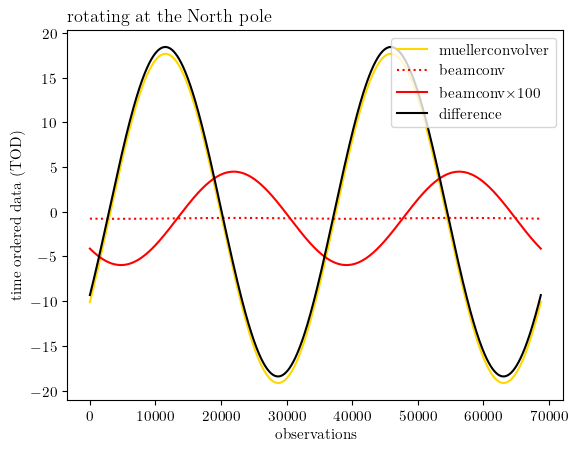

In [30]:
diff_North = TOD_muellerconvolver_North - TOD_beamconv_North

# plotting diff
plt.plot(TOD_muellerconvolver_North, color='gold', label="muellerconvolver")
plt.plot(TOD_beamconv_North, color='red', linestyle=':', label="beamconv")
plt.plot(np.mean(TOD_beamconv_North)+100*(TOD_beamconv_North-np.mean(TOD_beamconv_North)), color='red', label=r"beamconv$\times$100")
plt.plot(diff_North, color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('rotating at the North pole',loc='left')
plt.show()

Both framework return a TOD that oscillates twice as fast as the beam rotates, which is what we expect for a Gaussian beam. There are however two crucial differences:
- The two TOD oscillate around two (slightly) different values (see output below);
- The amplitude and phase of the oscillations are different in the two cases (see plot above).

In [31]:
print(np.mean(TOD_muellerconvolver_North))
print(np.mean(TOD_beamconv_North))

-0.755326302906746
-0.7491261703432509


## 2 Offset detector (instead of boresight)

We want to be able to handle offset detectors (i.e. not at boresight). This functionality has already been implemented in <tt>beamconv</tt> (only for the <tt>LiteBIRD-like</tt> branch though) and here we show how to reproduce the same results with <tt>ducc</tt>.

First, we need to define our offset quaternion.

In [32]:
off_quats = np.zeros((ndet,2,4))

off_ra, off_dec, off_pa = 10., 87., 10.
off_quats[0,0,:] = qp.QPoint().radecpa2quat(off_ra, off_dec, off_pa)

To feed the offset quaternion in <tt>beamconv</tt>, is enough to specify quats in the <tt>beam_options</tt>.

from line 4556 of instrument.py: [-2.77555756e-17  2.57792616e-02  4.54557937e-03  9.99657325e-01]


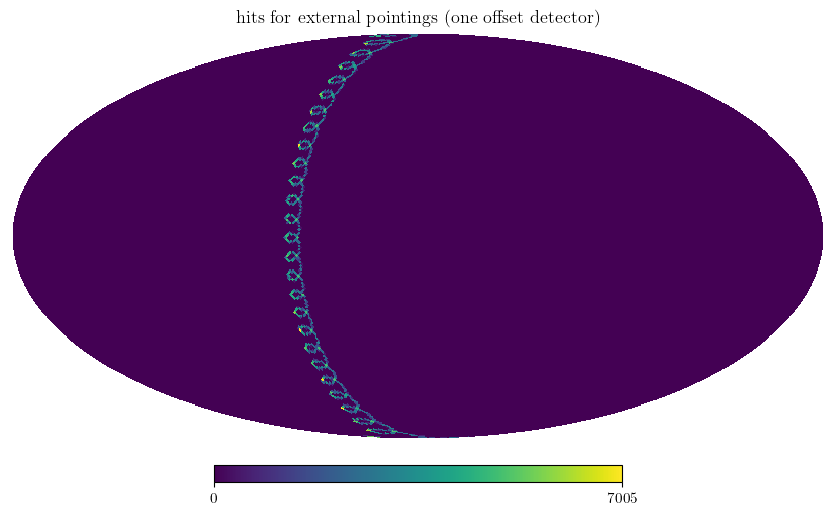

In [33]:
# setting up the beam options
beam_opts_quats = dict(btype='PO',
                       lmax=lmax,
                       mmax=lmax,
                       deconv_q=True,
                       normalize=False,
                       po_file="gaussian_beam.npy",
                       hwp_mueller=random_mueller,
                       quats=off_quats)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_quats)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.degrees(hwp_angles))

S_ptg.scan_instrument_mpi(random_slm.copy(), save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=True, beam_v=True, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

hp.mollview(proj[0], title=r'')
plt.title('hits for external pointings (one offset detector)')

TOD_beamconv_quat = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv_quat = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv_quat = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

For <tt>ducc</tt>, instead, we need to define the rotated quaternions. Note the definition of the quaternions for <tt>ducc</tt> that reflects the different conventions.

In [34]:
ptg4ducc = np.copy(ptg)

q_bore_ducc = ducc0.misc.ptg2quat(ptg4ducc)

off_quat = np.roll(off_quats[0,0],-1) #CONVENTIONS!
off_quat[0] *= -1                     #CONVENTIONS!

new_quats = np.empty((nsamp,4))

pp = ducc0.pointingprovider.PointingProvider(t0=0., freq=fsamp, quat=q_bore_ducc, nthreads=1)
rotated_quats = pp.get_rotated_quaternions(t0=0., freq=fsamp, rot=off_quat, rot_left=True, out=new_quats)

rotated_pointings = np.empty((nsamp, 3))

for k in np.arange(nsamp):
    rotated_pointings[k] = ducc0.misc.quat2ptg(rotated_quats[k])

And ensure that $\theta$, $\phi$ and $\psi$ are within the appropriate ranges.

In [35]:
rotated_pointings[np.where(rotated_pointings[:,1]<0),1] += 2*np.pi
rotated_pointings[np.where(rotated_pointings[:,2]<0),2] += 2*np.pi

print('theta between '+str(np.min(rotated_pointings[:,0]))+' and '+str(np.max(rotated_pointings[:,0])))
print('phi between '+str(np.min(rotated_pointings[:,1]))+' and '+str(np.max(rotated_pointings[:,1])))
print('psi between '+str(np.min(rotated_pointings[:,2]))+' and '+str(np.max(rotated_pointings[:,2])))

theta between 0.003891018376132123 and 3.1255925100043136
phi between 3.5858834732616085e-05 and 6.283149211348121
psi between 9.734115001824861e-07 and 6.2831782841795345


To test that we are indeed looking at the same pixels, we print the maximum of the difference of the two hit maps. Also, we plot the observed pixels as a function of time, and the polarization angle as a function of time.

In [36]:
pixs = hp.ang2pix(nside, rotated_pointings[:,0], rotated_pointings[:,1])
hits1 = np.bincount(pixs,minlength=npix)

print(np.max(proj[0]-hits1))

0.0


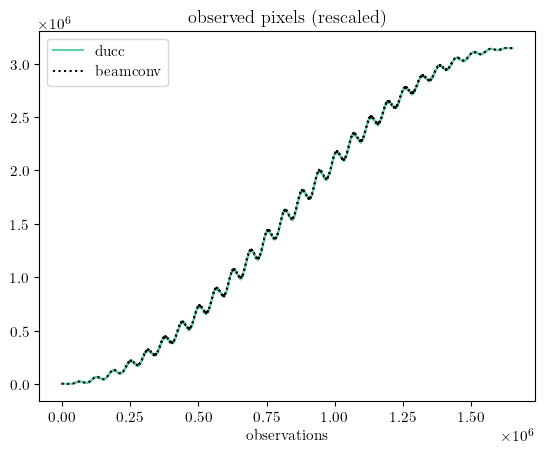

In [37]:
plt.plot(pixs*(nside_spin/nside)**2, color='mediumaquamarine', label='ducc')
plt.plot(pixels_beamconv_quat, color='black', linestyle=':', label='beamconv')
plt.title(r'observed pixels (rescaled)')
plt.xlabel('observations')
plt.legend()
plt.show()

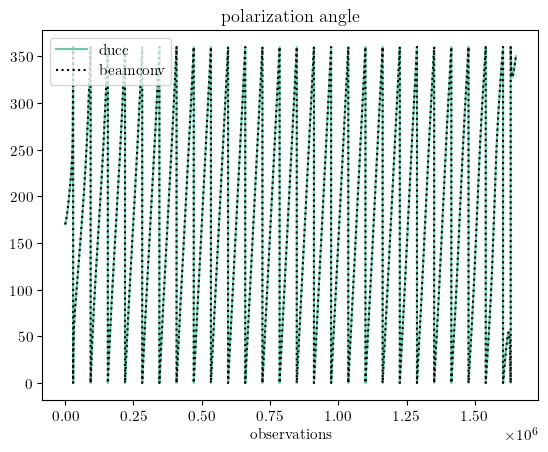

In [38]:
plt.plot(np.degrees(rotated_pointings[:,2]), color='mediumaquamarine', label='ducc')
plt.plot(pa_beamconv_quat, color='black', linestyle=':', label='beamconv')
plt.title(r'polarization angle')
plt.xlabel('observations')
plt.legend()
plt.show()

Finally, we can compute the TOD with <tt>ducc</tt> and compare it with <tt>beamconv</tt>'s output.

In [39]:
# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=random_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
TOD_muellerconvolver_quat = fullconv.signal(ptg=rotated_pointings, alpha=hwp_angles)

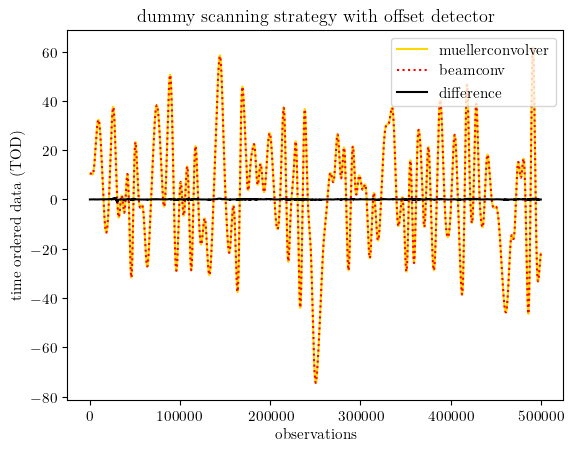

In [40]:
# plotting diff
plt.plot(TOD_muellerconvolver_quat[:500000], color='gold', label="muellerconvolver")
plt.plot(TOD_beamconv_quat[:500000], color='red', linestyle=':', label="beamconv")
plt.plot(TOD_muellerconvolver_quat[:500000]-TOD_beamconv_quat[:500000], color='black', label="difference")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with offset detector')
plt.show()

As we can see from the plot, there is very good agreement! See also the L2 error:

In [41]:
# L2 error
print("L2 error to beamconv + HWP + spin:", ducc0.misc.l2error(TOD_beamconv_quat, TOD_muellerconvolver_quat))

L2 error to beamconv + HWP + spin: 0.0036554984415137397


## 3 LiteBIRD-like scanning strategy

### 3.1 With <tt>beamconv</tt>
We have added an new module (<tt>scanning.py</tt>) in <tt>beamconv</tt> that allows to simulate a LiteBIRD-like scanning strategy. The <tt>scanning.py</tt> module is based on <a href="https://github.com/tmatsumu/LB_SYSPL_v4.2"><tt>pyScan</tt></a> written by Tomotake Matsumura (IPMU). By setting <tt>use_l2_scan = True</tt> in <tt>scan_instrument_mpi</tt>, the LiteBIRD-like scanning strategy is automatically implemented.

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-1650240
Implementing L2 scan
from line 4556 of instrument.py: [1. 0. 0. 0.]


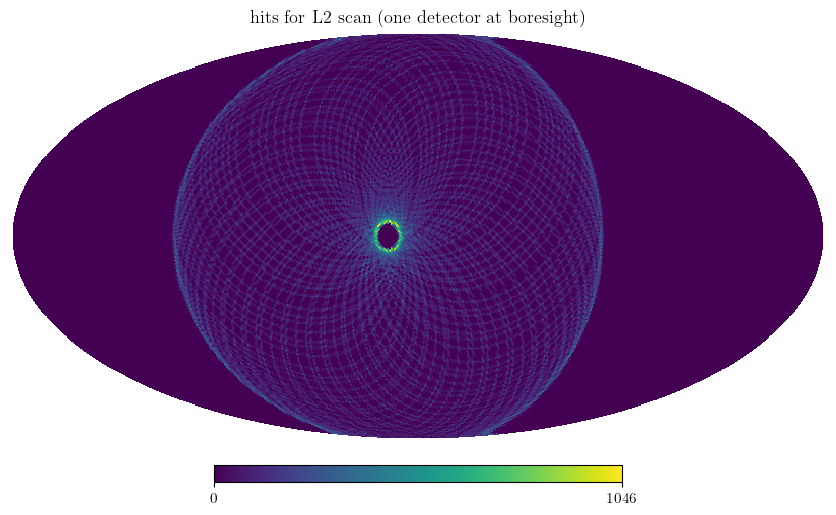

In [42]:
ctim0 = 0.1 #note that beamconv behaves weird if I set ctim0 to 0!
fwhm_arcmin = 5
single_beam = Beam(btype='Gaussian', fwhm=fwhm_arcmin, lmax=lmax)

S_L2 = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0)
S_L2.add_to_focal_plane(single_beam, combine=False)
S_L2.allocate_maps(nside=nside)
S_L2.scan_instrument_mpi(random_slm, save_tod=True, use_l2_scan=True,
                         ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_noiseless, cond, proj = S_L2.solve_for_map(return_proj = True)

tod_noiseless = S_L2.data(S_L2.chunks[0], beam=single_beam, data_type='tod').copy()

hp.mollview(proj[0], title=r'')
plt.title('hits for L2 scan (one detector at boresight)')

del(S_L2, cond, proj)

Provided with the boresight pointings, we can include some offset detectors and pass their quaternions as keyword arguments to <tt>input_focal_plane</tt>.

In [43]:
ndet = 4
quats = np.zeros((ndet,2,4))
quats[0,0,:] = np.array([1.,0.,0.,0.])
quats[1,0,:] = np.array([0.9958350838447524, 0.009165646421980997, 0.09071095143135842, 0.0])
quats[2,0,:] = np.array([0.9200679609994841, 0.03704627596838304, 0.08283588163313664, 0.3811046277509462])
quats[3,0,:] = np.array([0.9950353446904406, 0.05236230340491963, 0.08463363396964103, 0.0])

0.0 90.0 180.0
-5.769717159787511 79.53783401465752 174.2302828402125
-1.5953863857744952 79.58734658471758 133.4046136142255
-31.74482127130421 78.5766885646945 148.2551787286958
Scanning with 8 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-1650240
Implementing L2 scan
from line 4556 of instrument.py: [1. 0. 0. 0.]
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-1650240
Implementing L2 scan
from line 4556 of instrument.py: [0.99583508 0.00916565 0.09071095 0.        ]
[rank 000]: working on: det2, det2
[rank 000]:	Working on chunk 000: samples 0-1650240
Implementing L2 scan
from line 4556 of instrument.py: [0.92006796 0.03704628 0.08283588 0.38110463]
[rank 000]: working on: det3, det3
[rank 000]:	Working on chunk 000: samples 0-1650240
Implementing L2 scan
from line 4556 of instrument.py: [0.99503534 0.0523623  0.08463363 0.        ]


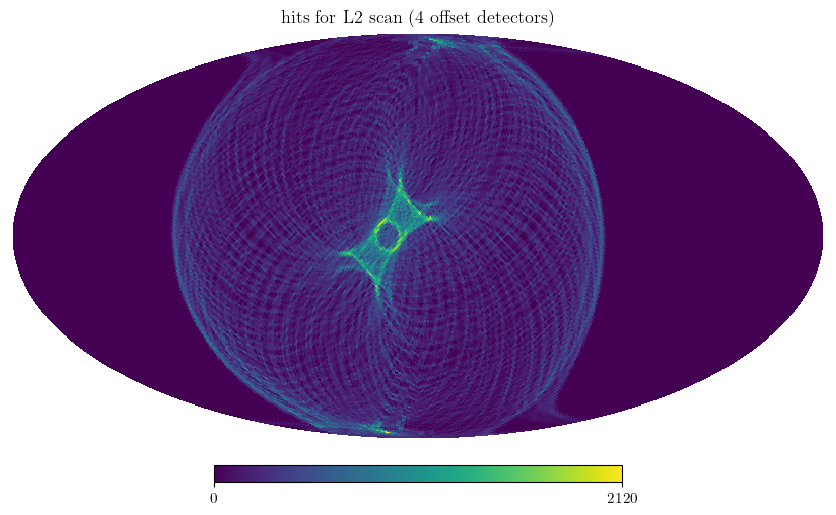

In [44]:
azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))

for i in np.arange(ndet):
    ra, dec, pa = qp.QPoint().quat2radecpa(quats[i,0,:])
    print(ra, dec, pa)

deads = np.array([[0,1],[0,1],[0,1],[0,1]])

# setting up the beam options
beam_opts_quats = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm_arcmin,
                 quats=quats
                 )

S_quats = ScanStrategy(duration=duration, sample_rate=fsamp, ctime0=ctim0)
S_quats.input_focal_plane(azs, els, polangs, deads=deads, combine=True, scatter=False, **beam_opts_quats)
S_quats.allocate_maps(nside=nside)
S_quats.scan_instrument_mpi(random_slm, save_tod=True, use_l2_scan=True, 
                            ctime_kwargs=dict(), q_bore_kwargs=dict())
out_maps_quats, cond, proj = S_quats.solve_for_map(return_proj = True)

tod_noiseless_quats = S_quats.data(S_quats.chunks[0], beam=single_beam, data_type='tod').copy()

hp.mollview(proj[0], title=r'hits for L2 scan (4 offset detectors)')

del(S_quats, out_maps_quats, cond)

### 3.1 With <tt>ducc</tt>

We use a slightly modified version of <tt>beamconv</tt>'s <tt>scanning.py</tt> (<tt>scanning_mod.py</tt>) that prepares LiteBIRD-like pointings for <tt>ducc</tt>. The only difference between <tt>scanning.py</tt>  and <tt>scanning_mod.py</tt> is the output's format. To check that everything works as it should, we repeat the same steps above and compare the hit maps.

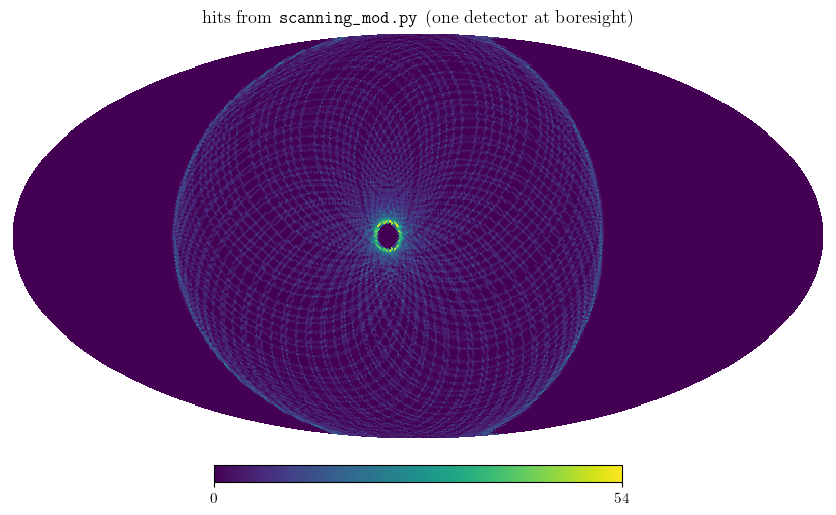

In [45]:
import scanning_mod

fquat = 1
nquat = int(duration*fquat+1)

ctime_quat = ctim0 + np.arange(nquat)/fquat
theta, phi, psi = scanning_mod.ctime2bore(ctime_quat)

pixs = hp.ang2pix(nside, theta, phi)

hits = np.bincount(pixs)
        
hp.mollview(hits, title=r'hits from \texttt{scanning_mod.py} (one detector at boresight)')
plt.show()

In [46]:
q_bore = np.empty((nquat, 4))

for i in np.arange(nquat):
    q_bore[i] = ducc0.misc.ptg2quat(np.array([theta[i],phi[i],np.pi-psi[i]])) #CONVENTIONS!

In [47]:
quats = np.zeros((2,2,4)) #different format than beamconv!
quats[0,0,:] = np.array([1.,0.,0.,0.])
quats[0,1,:] = np.array([0.9958350838447524, 0.009165646421980997, 0.09071095143135842, 0.0])
quats[1,0,:] = np.array([0.9200679609994841, 0.03704627596838304, 0.08283588163313664, 0.3811046277509462])
quats[1,1,:] = np.array([0.9950353446904406, 0.05236230340491963, 0.08463363396964103, 0.0])

In [48]:
hits_ducc = np.zeros(npix)

for i in np.arange(2):
    for j in np.arange(2):
        off_quat = np.roll(quats[i,j],-1) #CONVENTIONS!
        off_quat[0] *= -1                 #CONVENTIONS!
        
        print(off_quat)
        
        new_quats = np.empty((nsamp,4))

        pp = ducc0.pointingprovider.PointingProvider(t0=ctim0, freq=fquat, quat=q_bore, nthreads=1)
        rotated_quats = pp.get_rotated_quaternions(t0=ctim0, freq=fsamp, rot=off_quat, rot_left=True, out=new_quats)

        rotated_pointings = np.empty((nsamp, 3))

        for k in np.arange(nsamp):
            rotated_pointings[k] = ducc0.misc.quat2ptg(rotated_quats[k])

        pixs = hp.ang2pix(nside, rotated_pointings[:,0], rotated_pointings[:,1])

        hits_ducc += np.bincount(pixs,minlength=npix)

[-0.  0.  0.  1.]
[-0.00916565  0.09071095  0.          0.99583508]
[-0.03704628  0.08283588  0.38110463  0.92006796]
[-0.0523623   0.08463363  0.          0.99503534]


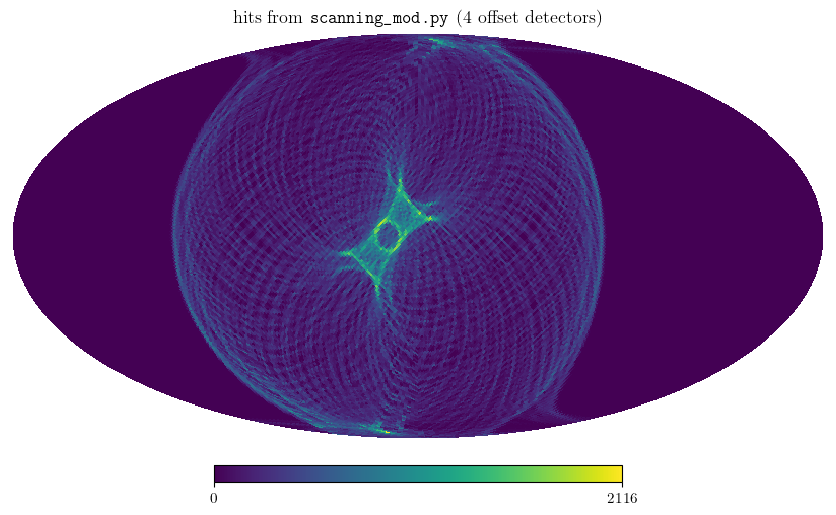

In [49]:
hp.mollview(hits_ducc, title=r'hits from \texttt{scanning_mod.py} (4 offset detectors)')
plt.show()

As a final check, we plot the difference of the two hit maps.

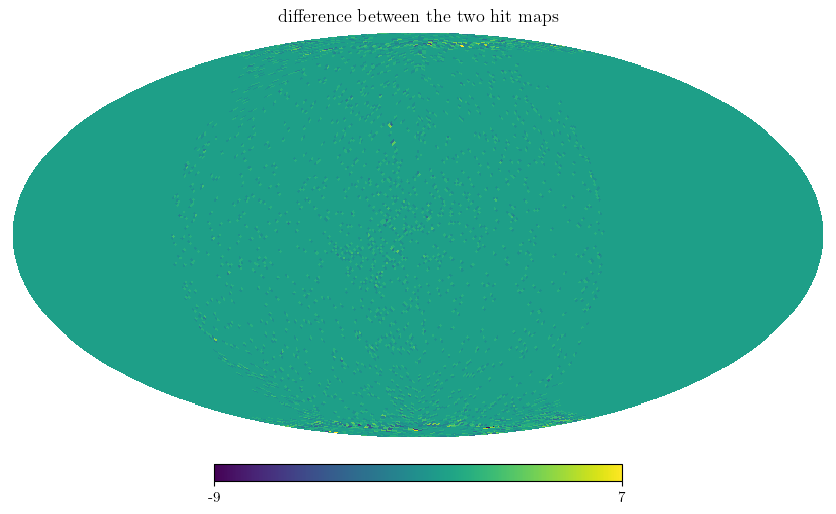

In [50]:
hp.mollview(hits_ducc-proj[0], title=r'difference between the two hit maps')
plt.show()

## 4 Gaussian beam from <tt>beamconv</tt> <font color="red">[in progress]</font>

Here we focus in reproducing <tt>beamconv</tt>'s Gaussian beam with <tt>ducc</tt>. <font color="red">[It might be related to healpy issue 861.]</font>

In [51]:
test_slm = random_slm.copy()
test_slm[1:] *= 0                                    #CHANGE HERE to set different sky components to zero

In [52]:
ndet = 1

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
deads = np.array([[0,1]])

In [53]:
# setting up the beam options
beam_opts_boresight = dict(btype='Gaussian',
                           lmax=lmax,
                           mmax=lmax,
                           deconv_q=True,
                           normalize=False,
                           fwhm=fwhm_arcmin,
                           hwp_mueller=random_mueller)

S_ptg = ScanStrategy(duration=duration, sample_rate=fsamp, external_pointing=True)
S_ptg.input_focal_plane(azs, els, polangs, deads=deads, **beam_opts_boresight)
S_ptg.allocate_maps(nside=nside)

S_ptg.set_hwp_mod(mode='stepped', freq=fsamp, angles=np.zeros_like(hwp_angles))#np.degrees(hwp_angles))

# determine nside_spin necessary for good accuracy
nside_spin = 1
while nside_spin < 4*lmax:
    nside_spin *= 2

S_ptg.scan_instrument_mpi(test_slm, save_tod=True, save_point=True, ctime_func=ctime_test, q_bore_func=q_bore_test, 
                          ctime_kwargs={'useless':0}, q_bore_kwargs={'useless':0},nside_spin=nside_spin,
                          interp=True, input_v=False, beam_v=False, max_spin=kmax+4, binning=True, verbose=0, 
                          mu_con_hwp=True, mu_con_spin=True,)

out_maps_ptg, cond, proj = S_ptg.solve_for_map(return_proj = True)

signal_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='tod').copy()
pixels_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pix').copy()
pa_beamconv = S_ptg.data(S_ptg.chunks[0], beam=S_ptg.beams[0][0], data_type='pa').copy()

del(S_ptg, cond)

from line 4556 of instrument.py: [1. 0. 0. 0.]


In [54]:
fwhm_rad = np.radians(fwhm_arcmin/60.)

# initialize empty beam
blm_gauss = np.zeros_like(random_blm)

# fill everything
blmtmp = utils.Blm_gauss_new(fwhm_rad,lmax,pol=True) #CHANGE HERE to use different ways to compute the beams
blm_gauss[0:3, 0:blmtmp.shape[1]] = blmtmp           #CHANGE HERE to set different beam components to zero

bls_gauss = utils.get_gauss_beam_from_beamconv(fwhm_rad, lmax)

# now do the same thing with MuellerConvolver
fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=test_slm,
    blm=blm_gauss,
    mueller=random_mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
signal_muellerconvolver = fullconv.signal(ptg=ptg, alpha=np.zeros_like(hwp_angles))#hwp_angles)

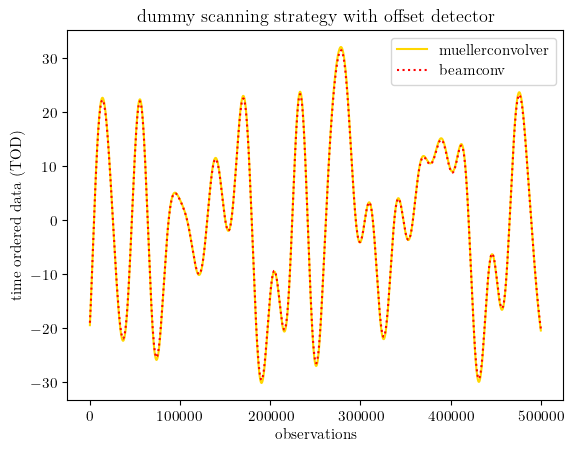

In [55]:
# plotting diff
plt.plot(signal_muellerconvolver[:500000], color='gold', label="muellerconvolver")
plt.plot(signal_beamconv[:500000], color='red', linestyle=':', label="beamconv")
plt.legend(loc='upper right')
plt.xlabel('observations')
plt.ylabel('time ordered data (TOD)')
plt.title('dummy scanning strategy with offset detector')
plt.show()

Steps above tried with <tt>get_gauss_beam_from_beamconv</tt> for:
- constant HWP angles (set to 0) and temperature-only random sky: it works;
- constant HWP angles (set to 0) and full random slm: <font color="red">no agreement!</font>

Steps above tried with <tt>blm_gauss_new</tt> for:
- constant HWP angles (set to 0) and temperature-only random sky: <font color="red">no agreement!</font>

Steps above tried with <tt>Blm_gauss_new</tt> for:
- constant HWP angles (set to 0) and temperature-only random sky: it works;
- constant HWP angles (set to 0) and full random slm: <font color="red">no agreement!</font>